# What's in a Name: NBA Hall Of Fame

Comparison is the foundation of sports. We do it all the time when talking about teams -- who has a better record, who has a better chance to win the championship, etc. Similarly, we do it all the time when talking about players -- who's the biggest, strongest, fastest; who scores the most, who dominates the paint, etc. 

In basketball, specifically in the NBA, a common critique of comparing players across all time periods is that different eras emphasized differnet aspects of the game. Thus, some say that we should only compare players from within the same era, but we disagree. We want to explore this opinion head on -- are today's players truly so much better than the greats of decades past? Did Michael Jordan really go up against "mailmen" quality players who played basketball as second job, or is that an oversimplifcation by LeBron fans?

We explore this grey area, and give quantifiable responses with respect to the quantifiable categories of the game. To do so, we pull from two datasets -- one that contains stats of active NBA players from the 2020-21 season, and one that contains stats of HOF inductees. We import and scrape these datasets, respectively -- with both requiring data cleaning/parsing. Both are stored in the Pandas DataFrame format, which gives us the ability to perform SQL-esque commands easily in a Python environment. 

We end by using regression analysis to predict whether a given active NBA player will enter the HOF based on their most recent performance. We understand that this model may underfit/overfit certain players (who are at the start/end of their careers), but for the most part, it will give us another valuable metric for comparison between eras.



In [35]:
# Data Collection - Pt.1
# Import the first dataset, found here: https://www.kaggle.com/umutalpaydn/nba-20202021-season-player-stats?select=nba2021_per_game.csv

from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

# pd.set_option("display.max_rows", None, "display.max_columns", None)
nba2021_df = pd.read_csv('nba2021_per_game.csv')

nba2021_df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,PF,21,MIA,28,2,14.6,2.6,4.4,0.590,0.0,0.0,0.000,2.6,4.4,0.590,0.590,1.3,2.4,0.561,1.3,2.7,4.0,0.6,0.4,0.5,1.0,1.9,6.5
1,Jaylen Adams,PG,24,MIL,6,0,2.8,0.2,1.3,0.125,0.0,0.3,0.000,0.2,1.0,0.167,0.125,0.0,0.0,0.000,0.0,0.5,0.5,0.3,0.0,0.0,0.0,0.2,0.3
2,Steven Adams,C,27,NOP,27,27,28.1,3.5,5.8,0.603,0.0,0.0,0.000,3.5,5.7,0.606,0.603,1.1,2.3,0.468,4.3,4.6,8.9,2.1,1.0,0.6,1.7,1.9,8.0
3,Bam Adebayo,C,23,MIA,26,26,33.6,7.4,12.9,0.573,0.1,0.2,0.400,7.3,12.7,0.576,0.576,5.1,6.0,0.841,1.9,7.3,9.2,5.3,1.0,1.0,3.0,2.6,19.9
4,LaMarcus Aldridge,C,35,SAS,18,18,26.7,5.9,12.5,0.476,1.3,3.7,0.358,4.6,8.8,0.525,0.529,0.9,1.2,0.762,0.8,3.5,4.3,1.9,0.4,0.9,0.9,1.5,14.1


In [24]:
# Data Parsing - Pt.1
# Clean the table by making sure all player entries are unique

players = nba2021_df.groupby('Player')

mult_teams = []
for player, player_df in players:
    if len(player_df.index) > 1:
        mult_teams.append(player)

for idx, row in nba2021_df.iterrows():
    # if a player played for multiple teams, we only want to keep their total stats
    if row.Player in mult_teams and row.Tm != 'TOT':
        nba2021_df = nba2021_df.drop([idx])

for player in mult_teams:
    # confirming that every player who played for multiple teams now only has one row (uniqueness)
    print(player, nba2021_df[nba2021_df.Player == player].shape[0])

# Data Collection - Pt.2
# Now that we have a fully unique datatset of current players, lets study HOF players (scrape data using Requests + BS4)

URL = 'https://www.basketball-reference.com/awards/hof.html'

req = requests.get(URL)
soup = bs(req.content, 'html.parser')

table = soup.find('table').prettify()
hof_df = pd.read_html(table, flavor = 'bs4')[0]

hof_df.head()


In [27]:
# Data Parsing - Pt.2

# The website has data as a multi-index, but we don't need the top level
hof_df.columns = hof_df.columns.droplevel()

# The table also contains non-player data, this isn't helpful to us
for idx, row in hof_df.iterrows():
   if row.Category != 'Player':
       hof_df = hof_df.drop([idx])

# Drop WNBA players since we're only studying NBA
for idx, row in hof_df.iterrows():
    if 'WNBA' in row.Name:
        hof_df = hof_df.drop(idx)

# The Name category has some extra stuff, lets drop it to only <firstName lastName> -- could just do this w a one-line lambda but we have some special cases with nicknames 
def fix_name(name):
    name_list = name.split()
    if len(name_list) == 2:     # if name is already in the right format
        return name
    new_name = ''
    for word in name_list:
        if word == 'Player':
            break
        new_name += word + ' '
    return new_name[:-1]     

hof_df['Name'] = hof_df['Name'].apply(lambda x: fix_name(x))

# Drop unnecessary cols:
hof_df = hof_df.drop(columns=['Unnamed: 14_level_1', 'G', 'W', 'L', 'W/L%'], axis=1)

hof_df = hof_df.sort_values(by=['Year'])

# Some non-NBA players are still in the Hall of Fame data frame
# Drop rows of the df that have PTS listed as NaN. This will remove all non-NBA players
hof_df = hof_df.dropna(subset=['PTS'])

# Cast the numbers in the main categories into floating points from strings (to prep data for analysis)
hof_df["Year"] = pd.to_numeric(pd.Series(hof_df["Year"])) 
hof_df["PTS"] = pd.to_numeric(pd.Series(hof_df["PTS"])) 
hof_df["TRB"] = pd.to_numeric(pd.Series(hof_df["TRB"])) 
hof_df["AST"] = pd.to_numeric(pd.Series(hof_df["AST"])) 
hof_df["BLK"] = pd.to_numeric(pd.Series(hof_df["BLK"])) 
hof_df["STL"] = pd.to_numeric(pd.Series(hof_df["STL"])) 

hof_df.head()

,Year,Name,Category,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
529,1959,George Mikan,Player,23.1,13.4,2.8,NaN,NaN,.404,NaN,.782,108.7,.249
512,1960,Ed Macauley,Player,17.5,7.5,3.2,NaN,NaN,.436,NaN,.761,100.4,.196
495,1961,Andy Phillip,Player,9.1,4.4,5.4,NaN,NaN,.368,NaN,.695,60.8,.101
440,1970,Bob Davies,Player,14.3,2.9,4.9,NaN,NaN,.378,NaN,.759,49.7,.148
434,1971,Bob Cousy,Player,18.4,5.2,7.5,NaN,NaN,.375,NaN,.803,91.1,.139


### Exploratory Data Analysis

Note, that by sorting the df, we see that certain metrics were not recorded back in the day (STL, BLK, 3P%). This alone is testament of the fact that the game has changed, and consequently, so have the factors that determine HOF worthiness. Let's move on to statistics that we do have, and explore how they vary through different eras.


(0.0, 23.955)

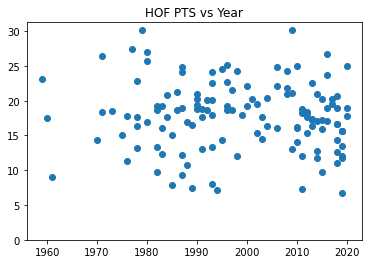

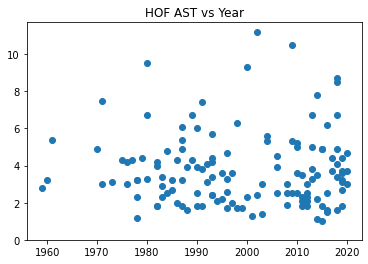

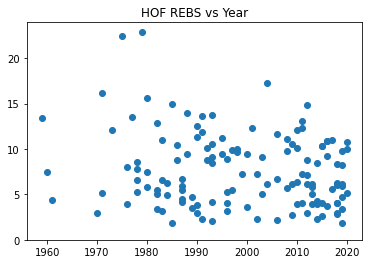

In [8]:
# Show a visual of how stats of hall of famers have changed through the years
plt.scatter(hof_df["Year"], hof_df["PTS"])
plt.title("HOF PTS vs Year")
plt.ylim(0)

plt.figure()
plt.scatter(hof_df["Year"], hof_df["AST"])
plt.title("HOF AST vs Year")
plt.ylim(0)

plt.figure()
plt.scatter(hof_df["Year"], hof_df["TRB"])
plt.title("HOF REBS vs Year")
plt.ylim(0)

# From the plots above it looks like Hall of Famers haven't really varied too much in terms of average number of points scored per game or assists per game. However, it is very interesting how the number of rebounds has decreased in the past few years - might have to do with how the league has gotten smaller with less dominant big men (the Steph Curry effect -- more spacing, more deep shooting, less interaction in the paint -> less rebounds)

# A problem with these graphs: not everyone has been inducted 5 years after they played. Some players inducted in the past few years have played way back in the 1960s or 70s, and are being inducted now. These graphs don't necessarily represent when the players actually played. We could explore this question further by finding the exact years the players have played and plotting based on that

In [9]:
currSeasonStats = pd.read_csv("nba2021_per_game.csv")

In [10]:
# build a footprint of the "average nba player today" by finding the mean points, rebounds, assists, steals, and blocks scored today
curr_points = np.mean(currSeasonStats["PTS"])
curr_assists = np.mean(currSeasonStats["AST"])
curr_rebounds = np.mean(currSeasonStats["TRB"])
curr_blocks = np.mean(currSeasonStats["BLK"])
curr_steals = np.mean(currSeasonStats["STL"])

#build a footprint of the average hall of famer by finding the mean in the same fashion as above
hof_points = np.mean(hof_df["PTS"])
hof_assists = np.mean(hof_df["AST"])
hof_rebounds = np.mean(hof_df["TRB"])
hof_blocks = np.mean(hof_df["BLK"])
hof_steals = np.mean(hof_df["STL"])

Text(0.5, 1.0, 'Steals')

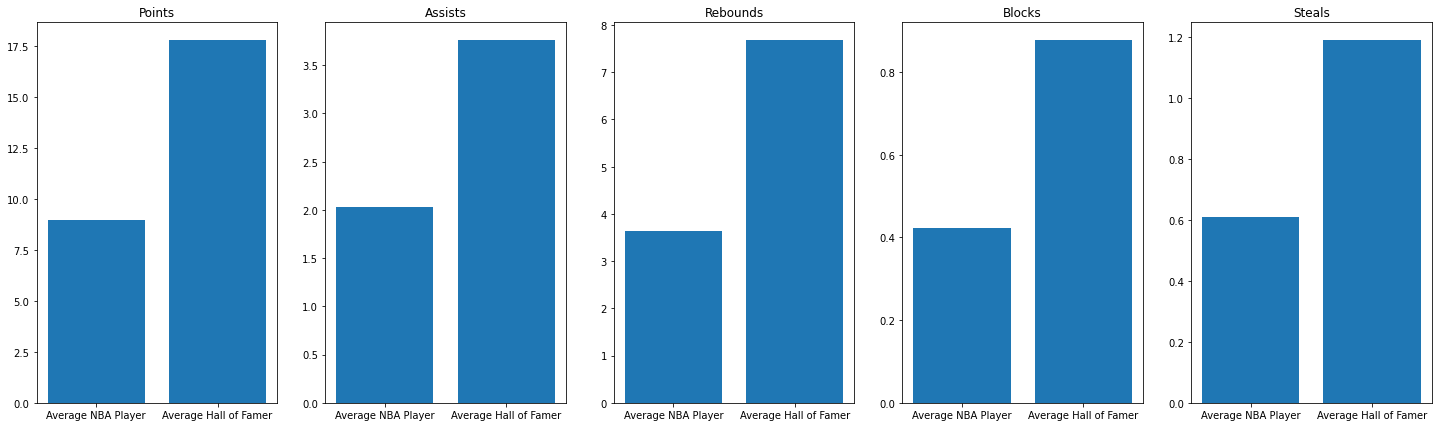

In [11]:
#compare the average player today with the average hall of famer across all categories

plt.figure(figsize=(25, 7))

plt.subplot(1, 5,1)
plt.bar(["Average NBA Player", "Average Hall of Famer"], [curr_points, hof_points])
plt.title("Points")

plt.subplot(1, 5,2)
plt.bar(["Average NBA Player", "Average Hall of Famer"], [curr_assists, hof_assists])
plt.title("Assists")

plt.subplot(1, 5, 3)
plt.bar(["Average NBA Player", "Average Hall of Famer"], [curr_rebounds, hof_rebounds])
plt.title("Rebounds")

plt.subplot(1, 5, 4)
plt.bar(["Average NBA Player", "Average Hall of Famer"], [curr_blocks, hof_blocks])
plt.title("Blocks")

plt.subplot(1, 5, 5)
plt.bar(["Average NBA Player", "Average Hall of Famer"], [curr_steals, hof_steals])
plt.title("Steals")

It's interesting how the ratio between an average player's stats and a hall of famers stats are NEARLY THE SAME across categories. The bars are almost perfectly aligned across the above graph. 

In [12]:
def calc_category_average(hof_df, category):
    player_category_stat = [float(stat) for stat in hof_df[category]]
    player_category_stat = list(filter(lambda x: np.isnan(x) == False , player_category_stat))
    avg_stat = sum(player_category_stat) / float(len(player_category_stat))
    return avg_stat

#avg_games = calc_category_average(hof_df, 'G')
avg_pts = calc_category_average(hof_df, 'PTS')
avg_trb = calc_category_average(hof_df, 'TRB')
avg_ast = calc_category_average(hof_df, 'AST')
avg_stl = calc_category_average(hof_df, 'STL')
avg_blk = calc_category_average(hof_df, 'BLK')

avg_stats = [avg_pts, avg_trb, avg_ast, avg_stl, avg_blk]

def get_player_stats(hof_df, player_name):
    for i, row in hof_df.iterrows():
        if row['Name'] == player_name:
            return [float(row['PTS']), float(row['TRB']), float(row['AST']), float(row['STL']), float(row['BLK'])]

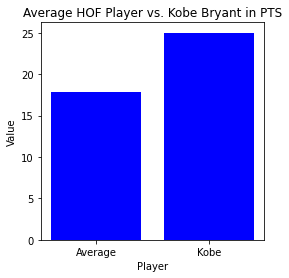

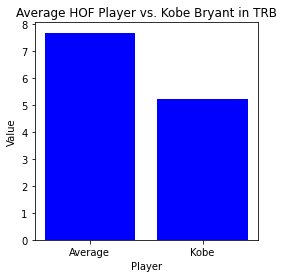

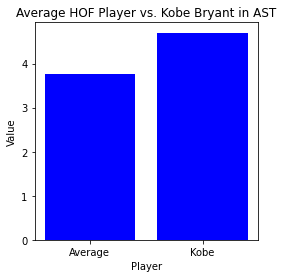

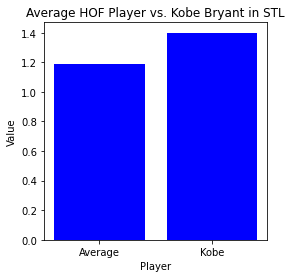

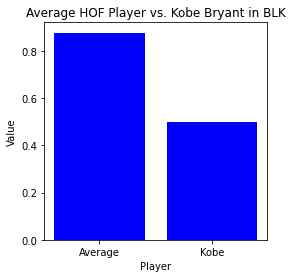

In [13]:
#In this example we will be examining a NBA player who many experts and analysts deem "great" to see how great of a basketball player such as Kobe Bryant compares to the average Hall of Fame stats

kobe_stats = get_player_stats(hof_df, 'Kobe Bryant')
categories = ['PTS', 'TRB', 'AST', 'STL', 'BLK']
# set width of bars

for i in range(len(categories)):
    fig = plt.figure(figsize = (4, 4))
    plt.bar(['Average', 'Kobe'], [avg_stats[i], kobe_stats[i]], color ='blue',
            width = 0.8)
    
    plt.xlabel("Player")
    plt.ylabel("Value")
    plt.title("Average HOF Player vs. Kobe Bryant in " + str(categories[i]))
    plt.show()

# Based on the graphs comparing the average HOF player and Kobe Bryant in a variety of categories we can see that Kobe Bryant was better offensively than the average HOF player with a higher PTS, and AST. He was however not as effective (compared to the average HOF player) in two main categories, both defenisve, and they were blocks and rebounds. What this shows is that exceptionally good players such as Kobe Bryant did not have to be the greatest defensively to be admitted to the HOF.

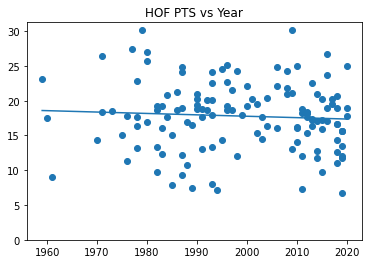

In [18]:
# Create linear regression model to see overall trend in HOF PTS across the years. We predict that PPG would be increasing over the years since players have become more skilled in scoring the ball.
plt.figure()
plt.scatter(hof_df["Year"], hof_df["PTS"])
plt.title("HOF PTS vs Year")
plt.ylim(0)
m,b = np.polyfit(hof_df["Year"], hof_df["PTS"], 1)
plt.plot(hof_df["Year"], m*hof_df["Year"] + b)

#Our model shows us that average PPG of HOF players over the years has not changed much, so our initial hypothesis was wrong. After seeing the distribution and the linear regression model, it makes sense as to why this is the case. While it can be assumed players have been more skilled in scoring the ball, players have become more skilled defensively as well. In the old NBA, the skill gap was too much between very skilled players and the average player which you could see through Wilt Chamberlein's career, as he even scored 100 points in a 1962 game. So across time, PPG was balanced overall as skill rose on both the defensive and offensive ends. 

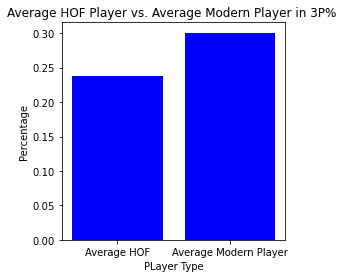

In [36]:
# In modern NBA, the "3 point shot" is a game changer. As the 3 point shot becomes more and more deadly, with more players attempting 3s as a means of scoring, we want to see how much has the 3 point shot evolved over time among HOF players. Most current HOF players aren't from the era of the 3 pointer as that era began 2013 upwards. We hypothesize that the average 3P% among HOF players won't be as high as the average 3P% from current players, because we believe that older pros did not care much about the 3-pointer in their time.

avg_3pt_hof = calc_category_average(hof_df,'3P%')
avg_3pt_curr = calc_category_average(currSeasonStats, '3P%')
fig = plt.figure(figsize = (4, 4))
plt.bar(['Average HOF', 'Average Modern Player'], [avg_3pt_hof, avg_3pt_curr], color ='blue',
        width = 0.8)

plt.xlabel("PLayer Type")
plt.ylabel("Percentage")
plt.title("Average HOF Player vs. Average Modern Player in 3P% ")
plt.show()

In [24]:
#Based on the results of our graph, our hypothesis that the average modern player's 3P% is higher than the average HOF player is correct. We see that the average modern player has about 6% higher 3P% than the average HOF player. As said earlier, this makes sense as players in today's era are more inclined to work on their 3-point shot as the 3 pointer's value is far higher than it used to be in the eras that most HOF players played in. 


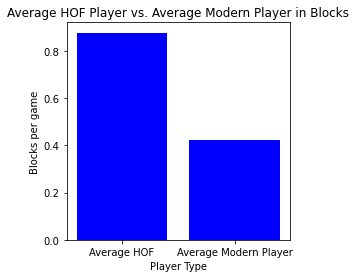

In [37]:
# The era that HOF players come from was also known as the "bully ball era" where players were very aggresive inside of the arc and more shots were taken inside of the arc. In the NBA it is more common to get blocked inside the arc since that's where layups occur so with that in mind, we hypothesize that the average HOF player would have more blocks than the average modern player, since the average HOF player would be from the "bully ball" era, more layups and inside shots occured than three pointers, so the probability for a block should be higher. Furthermore, as shown prior, three point shots have been more perfected and common among modern NBA players, and the 3 point shot usually is not as blocked as much as a field goal/inside shot. 

avg_blk_hof = calc_category_average(hof_df, 'BLK')
avg_blk_curr = calc_category_average(currSeasonStats, 'BLK')

fig = plt.figure(figsize = (4, 4))
plt.bar(['Average HOF', 'Average Modern Player'], [avg_blk_hof, avg_blk_curr], color ='blue',
        width = 0.8)

plt.xlabel("Player Type")
plt.ylabel("Blocks per game")
plt.title("Average HOF Player vs. Average Modern Player in Blocks")
plt.show()

In [34]:
# Based on the graph, we can conclude that our hypothesis is correct. The average HOF player has more blocks than the average modern nba player. This makes sense as more field goals, which are more frequenlty blocked than outside shots, were taken in the "bully ball" era than in the modern era where the 3 point shot rules. The difference is little more than double (~0.85 vs ~0.4) indiciating that the "bully ball" era was rougher and it was harder to score inside the paint at that time.

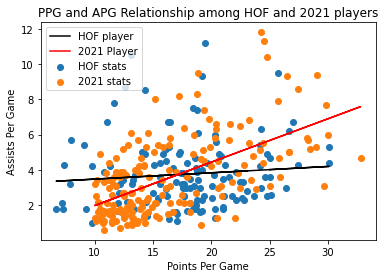

In [64]:
# How selfish does a HOF player have to be?
pts = np.array(hof_df['PTS']).reshape(-1,1)
ast = np.array(hof_df['AST']).reshape(-1,1)
model = linear_model.LinearRegression()
model.fit(pts, ast)
expected_ast = model.predict(pts)
plt.scatter(pts, ast, label='HOF stats')                           
plt.plot(pts, expected_ast, color = 'black', label='HOF player')                    
r1 = np.corrcoef(hof_df['PTS'], hof_df['AST'])
#2021 NBA players
pts = []
ast = []
for i,row in currSeasonStats.iterrows():
    # Reject nba players with less than 10 PPG because those aren't players that we should consider against HOF players since 
    # they are not high scoring enough players to consider(<10 PPG is low scoring).
    if float(row['AST']) < 0.0 or np.isnan(row['AST']) or float(row['PTS']) < 10.0 or np.isnan(row['PTS']):
        continue
    pts.append(float(row['PTS']))
    ast.append(float(row['AST']))

r2 = np.corrcoef(pts, ast)
pts = np.array(pts).reshape(-1,1)
ast = np.array(ast).reshape(-1,1)
model = linear_model.LinearRegression()
model.fit(pts, ast)
expected_ast = model.predict(pts)
plt.scatter(pts, ast, label='2021 stats')                           
plt.plot(pts, expected_ast, color = 'red', label='2021 Player')


plt.title('PPG and APG Relationship among HOF and 2021 players')          
plt.xlabel('Points Per Game')                                   
plt.ylabel('Assists Per Game') 
plt.legend()

In [65]:
print(r1) #R = .09 , indicating a weak correlation between PPG and APG among HOF players
print(r2) #R = 0.59, indicating a stronger correlation between PPG and APG among current nba players 

# What this graph shows is the relationship between high scoring HOF and how selfish they were (not passing the ball) compared to the realtionship between high-scoring 2021 NBA players and how selfish they are. The HOF line (black line) shows a weakly positive trend (R=.09) between PPG and APG. This indicates that high scoring HOF players, who played during the "bully ball" era, did not share the ball as much. So yes, while they were scoring a lot of points, they were not getting their team as involved. When we look at the 2021 players stats, we see there is a very strong posititve trend (R=.59) between PPG and APG. This means that current high scoring NBA players, still share the ball a lot and get their team involved while scoring a lot of points. This means that it can be said that among the offensive powerhouses among both HOF players and 2021 players, 2021 offensive powerhouses are less selfish, and are more willing to share the ball. It can be said that they are more offensively complete since they are scoring more points and helping their team score points.

[[1.         0.08847423]
 [0.08847423 1.        ]]
[[1.         0.58865413]
 [0.58865413 1.        ]]
